FER Training with Mini Xception Architecture

In [1]:
import os
import json
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Mini Xception model functions
from model import create_mini_xception, compile_model

#print("TensorFlow version:", tf.__version__)
#print("GPUs available:", len(tf.config.list_physical_devices('GPU')))

2025-10-14 02:47:58.345193: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-14 02:47:59.752660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-14 02:48:08.179959: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Configuration

In [2]:
# Configuration
DATA_DIR = "../../../Data/images"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "validation")

# Training parameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 25
EPOCHS_STAGE2 = 20
SEED = 42
NUM_CLASSES = 7

# Save paths
MODEL_TAG = "mini_xception_fer"
SAVE_DIR = "../../../models"
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_PATH = os.path.join(SAVE_DIR, f"{MODEL_TAG}.keras")
BEST_MODEL_PATH = os.path.join(SAVE_DIR, f"{MODEL_TAG}_best.keras")
CLASSMAP_PATH = os.path.join(SAVE_DIR, f"{MODEL_TAG}_classes.json")
HISTORY_PATH = os.path.join(SAVE_DIR, f"{MODEL_TAG}_history.json")

print(f"Data directory: {DATA_DIR}")
print(f"Model save path: {MODEL_PATH}")

Data directory: ../../../Data/images
Model save path: ../../../models/mini_xception_fer.keras


Define Data Generator Functions

In [3]:
def get_train_val_data_gen(folder_path, picture_size=48, batch_size=32, val_split=0.1, seed=42):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split,
        rotation_range=15,
        zoom_range=0.15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    
    train_ds = datagen.flow_from_directory(
        folder_path,
        target_size=(picture_size, picture_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='sparse',
        subset="training",
        seed=seed
    )
    
    val_ds = datagen.flow_from_directory(
        folder_path,
        target_size=(picture_size, picture_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='sparse',
        subset="validation",
        seed=seed
    )
    
    return train_ds, val_ds

def get_test_data_gen(test_folder_path, picture_size=48, batch_size=32):
    datagen_test = ImageDataGenerator(rescale=1./255)
    test_ds = datagen_test.flow_from_directory(
        test_folder_path,
        target_size=(picture_size, picture_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )
    return test_ds

print("Data generator functions defined!")

Data generator functions defined!


Create Data Generators

In [4]:
train_generator, val_generator = get_train_val_data_gen(
    folder_path=TRAIN_DIR,
    picture_size=48,
    batch_size=BATCH_SIZE,
    val_split=0.1,
    seed=SEED
)

test_generator = get_test_data_gen(
    test_folder_path=TEST_DIR,
    picture_size=48,
    batch_size=BATCH_SIZE
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class labels: {list(train_generator.class_indices.keys())}")

# Save class mapping
class_map = train_generator.class_indices
with open(CLASSMAP_PATH, "w") as f:
    json.dump(class_map, f, indent=2)
print("Saved class mapping ->", CLASSMAP_PATH)

Found 25942 images belonging to 7 classes.
Found 2879 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Training samples: 25942
Validation samples: 2879
Test samples: 7066
Number of classes: 7
Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Saved class mapping -> ../../../models/mini_xception_fer_classes.json


Build Mini Xception Model

In [5]:
print("Creating Mini Xception model...")
model = create_mini_xception(input_shape=(48, 48, 1), num_classes=train_generator.num_classes)
model = compile_model(model)

model.summary()
print(f"Total parameters: {model.count_params():,}")

Creating Mini Xception model...


2025-10-14 02:48:51.077451: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 48, 48, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 24, 24, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 12, 12, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 50,631 (197.78 KB)

 Trainable params: 49,223 (192.28 KB)

 Non-trainable params: 1,408 (5.50 KB)

Total parameters: 50,631


Define Callbacks

In [6]:
callbacks = [
    ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_accuracy",
        patience=12,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=6,
        min_lr=1e-7,
        verbose=1
    ),
]

print("Callbacks defined!")

steps_per_epoch = max(1, math.ceil(train_generator.samples / train_generator.batch_size))
validation_steps = max(1, math.ceil(val_generator.samples / val_generator.batch_size))

Callbacks defined!


Stage 1 Training

Starting Stage 1 training (25 epochs)...


/opt/conda/envs/ml-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2264 - loss: 1.9472
Epoch 1: val_accuracy improved from -inf to 0.30010, saving model to ../../../models/mini_xception_fer_best.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 936s 1s/step - accuracy: 0.2265 - loss: 1.9471 - val_accuracy: 0.3001 - val_loss: 1.7163 - learning_rate: 0.0010
Epoch 2/25
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.2996 - loss: 1.7227
Epoch 2: val_accuracy did not improve from 0.30010
811/811 ━━━━━━━━━━━━━━━━━━━━ 380s 468ms/step - accuracy: 0.2996 - loss: 1.7226 - val_accuracy: 0.2609 - val_loss: 1.7989 - learning_rate: 0.0010
Epoch 3/25
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.3404 - loss: 1.6474
Epoch 3: val_accuracy improved from 0.30010 to 0.37965, saving model to ../../../models/mini_xception_fer_best.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 305s 376ms/step - accuracy: 0.3404 - loss: 1.6474 - val_accuracy: 0.3796 - val_loss: 1.5818 - learning_rate: 0.0010
Epoch 4/25
811/811 ━━━━━━

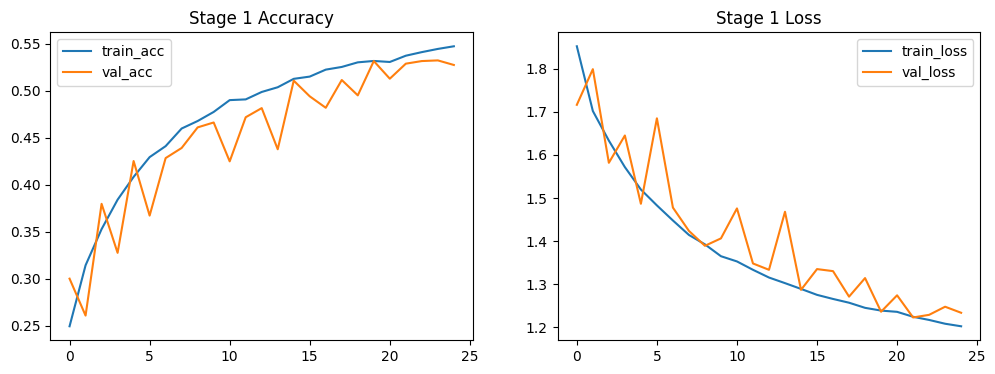

In [7]:
print(f"Starting Stage 1 training ({EPOCHS_STAGE1} epochs)...")

history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history_stage1.history["accuracy"], label="train_acc")
plt.plot(history_stage1.history["val_accuracy"], label="val_acc")
plt.title("Stage 1 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_stage1.history["loss"], label="train_loss")
plt.plot(history_stage1.history["val_loss"], label="val_loss")
plt.title("Stage 1 Loss")
plt.legend()
plt.show()

Stage 2 Training (Fine-Tuning)

Fine-tuning Stage 2 (20 epochs)...
Epoch 1/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5578 - loss: 1.1909
Epoch 1: val_accuracy improved from 0.53213 to 0.54394, saving model to ../../../models/mini_xception_fer_best.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 298s 360ms/step - accuracy: 0.5578 - loss: 1.1909 - val_accuracy: 0.5439 - val_loss: 1.1848 - learning_rate: 1.0000e-05
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5519 - loss: 1.1833
Epoch 2: val_accuracy improved from 0.54394 to 0.56061, saving model to ../../../models/mini_xception_fer_best.keras
811/811 ━━━━━━━━━━━━━━━━━━━━ 298s 367ms/step - accuracy: 0.5519 - loss: 1.1833 - val_accuracy: 0.5606 - val_loss: 1.1708 - learning_rate: 1.0000e-05
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5557 - loss: 1.1726
Epoch 3: val_accuracy did not improve from 0.56061
811/811 ━━━━━━━━━━━━━━━━━━━━ 294s 363ms/step - accuracy: 0.5557 - loss: 1.1726 - val_accuracy: 0.5561 - val_loss: 1.16

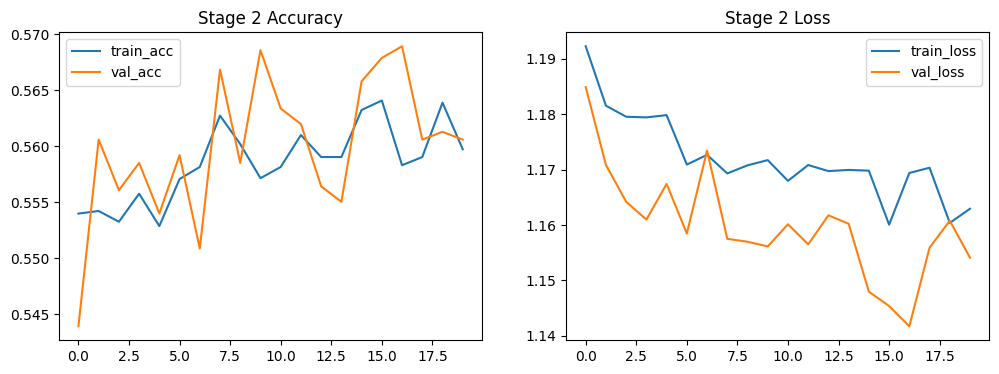

In [8]:
print(f"Fine-tuning Stage 2 ({EPOCHS_STAGE2} epochs)...")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history_stage2.history["accuracy"], label="train_acc")
plt.plot(history_stage2.history["val_accuracy"], label="val_acc")
plt.title("Stage 2 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_stage2.history["loss"], label="train_loss")
plt.plot(history_stage2.history["val_loss"], label="val_loss")
plt.title("Stage 2 Loss")
plt.legend()
plt.show()

Save Training History

In [9]:
hist = {
    "stage1": {k: [float(x) for x in v] for k, v in history_stage1.history.items()},
    "stage2": {k: [float(x) for x in v] for k, v in history_stage2.history.items()}
}

with open(HISTORY_PATH, "w") as f:
    json.dump(hist, f, indent=2)

print("Saved training history ->", HISTORY_PATH)

Saved training history -> ../../../models/mini_xception_fer_history.json


Save Model

In [10]:
print("Loading best model and saving final version...")

try:
    best_model = keras.models.load_model(BEST_MODEL_PATH)
    best_model.save(MODEL_PATH)
    print("Model saved successfully ->", MODEL_PATH)
except Exception as e:
    print(f"Error: {e}")
    # fallback: save current model
    model.save(MODEL_PATH)
    print("Saved current model ->", MODEL_PATH)

Loading best model and saving final version...
Model saved successfully -> ../../../models/mini_xception_fer.keras


Combined Curves

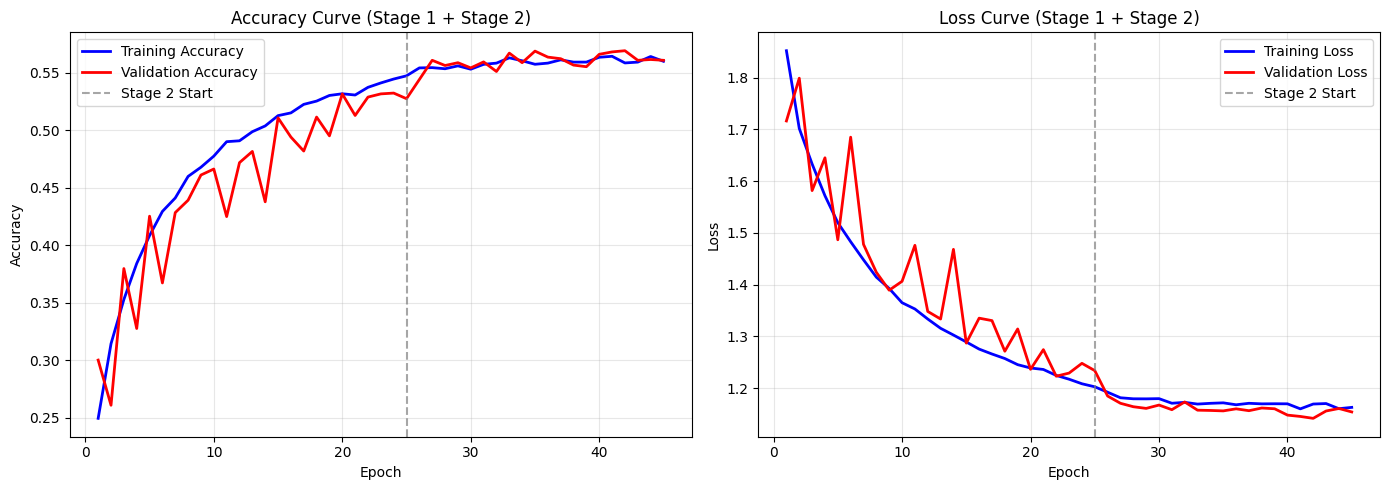


=== Training Summary ===
Best Validation Accuracy: 0.5689 (Epoch 42)
Final Validation Accuracy: 0.5606
Total Epochs: 45

==== Training Complete! ====
Files saved:
   - Final Model: ../../../models/mini_xception_fer.keras
   - Best Model: ../../../models/mini_xception_fer_best.keras
   - Classes: ../../../models/mini_xception_fer_classes.json
   - History: ../../../models/mini_xception_fer_history.json


In [11]:
def plot_combined_history(hist):
    stage1_epochs = len(hist['stage1']['accuracy'])
    stage2_epochs = len(hist['stage2']['accuracy'])

    all_epochs = list(range(1, stage1_epochs + stage2_epochs + 1))
    all_train_acc = hist['stage1']['accuracy'] + hist['stage2']['accuracy']
    all_val_acc = hist['stage1']['val_accuracy'] + hist['stage2']['val_accuracy']
    all_train_loss = hist['stage1']['loss'] + hist['stage2']['loss']
    all_val_loss = hist['stage1']['val_loss'] + hist['stage2']['val_loss']

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(all_epochs, all_train_acc, label="Training Accuracy", color='blue', linewidth=2)
    plt.plot(all_epochs, all_val_acc, label="Validation Accuracy", color='red', linewidth=2)
    plt.axvline(x=stage1_epochs, color="gray", linestyle="--", alpha=0.7, label="Stage 2 Start")
    plt.title("Accuracy Curve (Stage 1 + Stage 2)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(all_epochs, all_train_loss, label="Training Loss", color='blue', linewidth=2)
    plt.plot(all_epochs, all_val_loss, label="Validation Loss", color='red', linewidth=2)
    plt.axvline(x=stage1_epochs, color="gray", linestyle="--", alpha=0.7, label="Stage 2 Start")
    plt.title("Loss Curve (Stage 1 + Stage 2)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    best_val_acc = max(all_val_acc)
    best_epoch = all_val_acc.index(best_val_acc) + 1
    final_val_acc = all_val_acc[-1]
    
    print(f"\n=== Training Summary ===")
    print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Total Epochs: {len(all_epochs)}")

# Plot history
plot_combined_history(hist)

print("\n==== Training Complete! ====")
print(f"Files saved:")
print(f"   - Final Model: {MODEL_PATH}")
print(f"   - Best Model: {BEST_MODEL_PATH}")
print(f"   - Classes: {CLASSMAP_PATH}")
print(f"   - History: {HISTORY_PATH}")